# Scoring using 10 trained XGBoost classifiers

In [4]:
!ls -l /data/cell_segmentation/BoostedTrees.pkl

-rw-r--r-- 1 yfreund freund 7311987 Nov 16 17:51 /data/cell_segmentation/BoostedTrees.pkl


In [8]:

size = getsize('/data/cell_segmentation/BoostedTrees.pkl')
size

7311987

In [2]:
%%writefile calcPredictions.py

import numpy as np
from numpy import *
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh
import pandas as pd
from glob import glob
import pickle as pk
from  os.path import getsize # get the size of file. 
from lib.logger import logger
print('version of xgboost is:',xgb.__version__,'should be at least 1.5.0')

def read_csv_files(pattern='/data/cell_segmentation/DK55/CH3/*/puntas_*.csv'):
    files=glob(pattern)
    files=sorted(files)
    print(len(files),' csv files')

    df_list=[]

    for filename in files:
        size=getsize(filename)
        if size <10:
            #print('skipping',filename,'size=',size)
            continue
        df=pd.read_csv(filename)
        #print(filename,df.shape)
        df_list.append(df)
    print(len(df_list),'non empty csv files')

    full_df=pd.concat(df_list)
    full_df.index=list(range(full_df.shape[0]))
    print('number of candidate cells:',full_df.shape[0])
    return full_df

def read_classifier(filename='/data/cell_segmentation/BoostedTrees.pkl'):
    with open(filename,'br') as pkl_file:
        bst_list=pk.load(pkl_file)
    return bst_list


def calculate_scores(df,bst_list):
    drops = ['animal', 'section', 'index', 'row', 'col','label']

    def createDM(df):
        labels=df['label']
        features=df.drop(drops,axis=1)
        return xgb.DMatrix(features, label=labels)
    # Calculate predictions according to each boosted tree in the ensemble
    AllDM=createDM(df)
    labels=AllDM.get_label()
    scores=np.zeros([df.shape[0],len(bst_list)])
    for i in range(len(bst_list)):
        bst=bst_list[i]
        scores[:,i] = bst.predict(AllDM, iteration_range=[1,bst.best_ntree_limit],\
                                  output_margin=True)
    return scores


def calc_score_stats(scores,full_df):
    _mean=np.mean(scores,axis=1)
    _std=np.std(scores,axis=1)

    _mean= np.mean(scores,axis=1)
    full_df['mean_score']= _mean 
    _std=np.std(scores,axis=1)
    full_df['std_score']=_std
    _median = np.median(scores,axis=1)
    full_df['median_score']=_median
    _spread=np.percentile(scores,90,axis=1) - np.percentile(scores,10,axis=1)
    full_df['score_spread']=_spread
    return full_df

def gen_decision():
    def points2line(p1,p2,i):
        x1,y1=p1
        x2,y2=p2
        a=(y1-y2)/(x1-x2)
        b=y1-a*x1
        #plotline(a,b,i)
        return a,b

    p=[[0,0.8],[2,2.5],[0,3.3],[-2,2.5],[-10,4],[10,4]]

    def plotline(a,b,i):
        X=arange(-5,5,0.01)
        Y=a*X+b
        plot(X,Y,label=str(i))

    def aboveline(p,l):
        return l[0]*p[0]+l[1] < p[1]

    L=[]
    L.append(points2line(p[0],p[1],0))
    L.append(points2line(p[1],p[2],1))
    L.append(points2line(p[2],p[3],2))
    L.append(points2line(p[3],p[0],3))
    L.append(points2line(p[1],p[5],4))
    L.append(points2line(p[3],p[4],5))


    def decision(x,y):
        p=[x,y]
        if aboveline(p,L[0]) and not aboveline(p,L[1])\
        and not aboveline(p,L[2]) and aboveline(p,L[3]):
            return 0
        if (x<0 and not aboveline(p,L[5])) or (x>0 and aboveline(p,L[4])):
            return -2
        if (x>0 and not aboveline(p,L[4])) or (x<0 and aboveline(p,L[5])):
            return 2
    return decision

#classification rule
bst_list=read_classifier('/data/cell_segmentation/BoostedTrees.pkl')
decision=gen_decision()

#feature data and scores
full_df=read_csv_files('/data/cell_segmentation/DK55/CH3/*/puntas_*.csv')
scores=calculate_scores(full_df,bst_list)
full_df=calc_score_stats(scores,full_df)

predictions=[]
for i,row in full_df.iterrows():
    p=decision(float(row['mean_score']),float(row['std_score']))
    predictions.append(p)
    if i %100==0:
        print('\r%d'%i,end='')
full_df['predictions']=predictions

DATA_DIR='/data/cell_segmentation'

detection_df=full_df[full_df['predictions']!=-2]
detection_df = detection_df[['animal', 'section', 'row', 'col','label', 'mean_score',
       'std_score', 'predictions']]
detection_df.to_csv(DATA_DIR+'/detections_DK55.2.csv',index=False)


Overwriting calcPredictions.py


In [2]:
!ls -lrt $DATA_DIR/*.csv

-rw-r--r-- 1 yfreund freund 68929387 Nov 21 10:37 /data/cell_segmentation/demo_scores.csv
-rw-r--r-- 1 yfreund freund 10296443 Dec 17 16:05 /data/cell_segmentation/DK55.Predicted.csv
-rw-r--r-- 1 yfreund freund   848935 Dec 17 16:06 /data/cell_segmentation/detections_DK55.csv
-rw-r--r-- 1 yfreund freund   848935 Dec 17 17:44 /data/cell_segmentation/detections_DK55.2.csv


### Visualizations

In [15]:
from collections import Counter
Counter(predictions)

Counter({-2: 787579, 2: 12224, 0: 1420})

Populating the interactive namespace from numpy and matplotlib


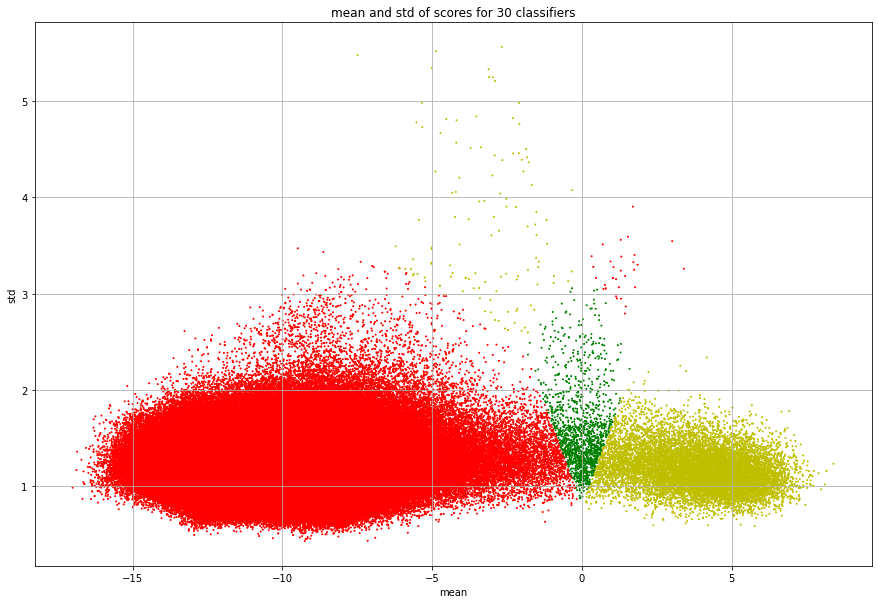

In [20]:
%pylab inline
figure(figsize=[15,10])
cmap={-2:'r',
      -1:'b',
      0:'g',
      1:'m',
      2:'y',
      3:'c'}
_colors=[cmap[int(i)] for i in list(predictions)]
scatter(_mean,_std,c=_colors,s=1)

title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()



In [21]:
Without_negatives = full_df[full_df['predictions']>-2]
full_df.shape, Without_negatives.shape

((801223, 51), (13644, 51))

In [22]:
Without_negatives.sort_values('section')
Without_negatives.tail()

,animal,section,index,label,area,height,width,row,col,corr_CH1,...,h4_CH_3,h5_CH_3,h6_CH_3,contrast1,contrast3,mean_score,std_score,median_score,score_spread,predictions
800982,DK55,452,1,0,2142,56,57,12493,22212,1.152276,...,-2.119240e-10,-5.003883e-08,-1.192421e-10,0.306896,0.365458,1.528494,1.574169,1.332732,4.160342,2
800987,DK55,453,0,0,1750,41,60,16102,32397,1.066820,...,6.741206e-11,2.197480e-07,2.193908e-11,0.201591,0.221735,0.217495,1.152769,0.082540,2.476741,0
801146,DK55,465,0,0,3082,72,57,18748,23655,0.711680,...,2.592957e-11,1.212679e-07,2.461488e-12,0.169952,0.220336,2.345560,1.037871,2.285298,2.570716,2
801149,DK55,466,0,0,1988,69,43,12635,29003,1.014039,...,-1.722145e-09,-1.281637e-06,-5.798086e-09,0.273288,0.311930,0.096834,1.536437,0.188553,3.913078,0
801157,DK55,466,8,0,2865,64,78,17360,25790,1.052875,...,-3.774891e-09,-2.045354e-06,2.390335e-09,0.335362,0.283301,1.229135,1.051489,1.174953,2.002706,2


In [23]:
Without_negatives.to_csv(DATA_DIR+'DK55.Predicted.csv')
!ls -lh $DATA_DIR/DK55.Predicted.csv

-rw-r--r-- 1 yfreund freund 9.9M Dec 17 16:05 /data/cell_segmentation//DK55.Predicted.csv


In [24]:
Counter(full_df['predictions'])

Counter({-2: 787579, 2: 12224, 0: 1420})

In [28]:
!head $DATA_DIR/detections_DK55.csv

animal,section,row,col,label,mean_score,std_score,predictions
DK55,3,13128,26163,0,1.601302043100198,1.089851684309673,2
DK55,3,17560,28916,0,3.153772230943044,1.237028158087835,2
DK55,7,16237,23433,0,0.4688288763165474,1.0427184115671002,2
DK55,29,19485,24248,0,2.9410623629887898,1.2527776970419338,2
DK55,29,19728,24645,0,2.447337472438812,1.50955135260125,2
DK55,30,13951,19572,0,0.10220109423001607,1.7179075962953005,0
DK55,31,12955,26090,0,0.9877490213761727,1.392980848397488,2
DK55,32,14022,19608,0,-0.4440922807902098,1.6300619653457054,0
DK55,35,9937,26406,0,-0.32822866092125574,1.422662135135903,0


In [49]:
from collections import Counter
Counter(predictions)

Counter({-2: 116177, 0: 538, 2: 1475})

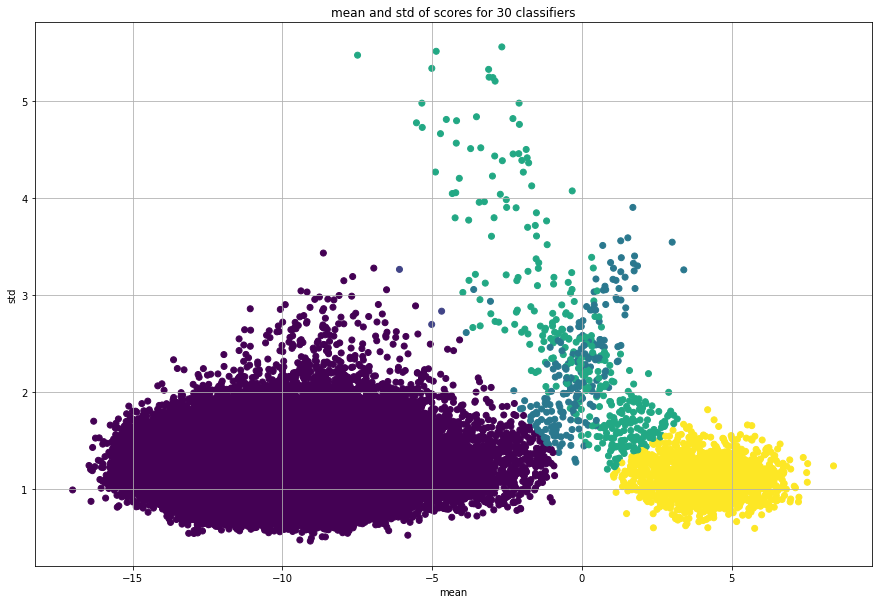

In [50]:
figure(figsize=[15,10])
scatter(_mean,_std,c=predictions+labels)

title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()

In [101]:
def solve(x1,x2,y1,y2):
    b=(y1-y2)/(x1-x2)
    a=0.5*(y1+y2-b*(x1+x2))
    return a,b

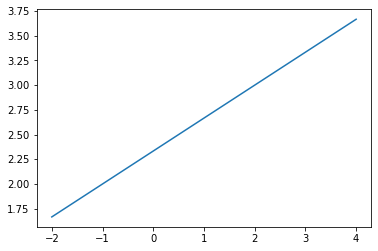

In [33]:
a,b=solve(-1,5,2,4)
x=arange(-2,5)
plot(x,a+b*x)

In [15]:
%pwd

'/Users/yoavfreund/projects/butons/XGBoost'

In [26]:
import pickle as pk
with open('../data/172/BoostedTrees.pkl','bw') as pkl_file:
    pk.dump(bst_list,pkl_file)
!ls -lh ../data/172/*.pkl

-rw-r--r--  1 yoavfreund  staff   2.2M Aug 16 10:53 ../data/172/BoostedTrees.pkl
-rw-r--r--  1 yoavfreund  staff   221M Aug 14 14:54 ../data/172/extracted_cells.pkl


In [ ]:
def plot_margins(_train_size):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        trainDM,testDM=split_data(df)
        legends=[]
        # Use early_stopping_rounds=5 to enable early stopping
        for num_round in [100]:
            bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
            y_pred = bst.predict(testDM, iteration_range=[0,bst.best_ntree_limit], output_margin=True)
            thresholds = sorted(np.unique(np.round(y_pred, 2)))
            error_cuv, error_ger = xgbh.get_error_values(y_pred, y_test, thresholds)
            legends += ['Cuviers %d'%num_round, 'Gervais %d'%num_round]
            _style=['y','g'] if num_round==100 else ['b', 'r']
            xgbh.get_margin_plot(error_cuv, error_ger, thresholds, legends = legends, style=_style)
        
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        thr = thresholds/(np.max(thresholds) - np.min(thresholds))
    plt.title('data_size=%4.3f'%(X_train.shape[0]))
    plt.show()

In [ ]:
plot_margins(0.03)

In [ ]:
plot_margins(0.1)

In [ ]:
plot_margins(0.8)

## Per example variation analysis
The CDFs provide information on the variation of the aggregate. If we want to estimate of the confidence on a single examples we need to compute the variance **per example**

In [ ]:
data  = np.load("Data/processed_data_15mb.np")
data.shape

In [ ]:
def get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp, num_chunks=20):
    error_cuv_bin = np.array(np.array(error_cuv_samp) * num_chunks, dtype=int)
    error_cuv_bin[error_cuv_bin == num_chunks] = num_chunks - 1
    error_ger_bin = np.array(np.array(error_ger_samp) * num_chunks, dtype=int)
    error_ger_bin[error_ger_bin == num_chunks] = num_chunks - 1
    
    min_cuv = np.zeros(num_chunks, dtype=float)
    max_cuv = np.zeros(num_chunks, dtype=float)
    min_ger = np.zeros(num_chunks, dtype=float)
    max_ger = np.zeros(num_chunks, dtype=float)
    
    normalizing_factor = (max(thresholds_samp) - min(thresholds_samp))
    
    for i in range(num_chunks):
        min_cuv[i] = thresholds_samp[np.min(np.where(error_cuv_bin == i))]/normalizing_factor
        max_cuv[i] = thresholds_samp[np.max(np.where(error_cuv_bin == i))]/normalizing_factor
        min_ger[i] = thresholds_samp[np.min(np.where(error_ger_bin == i))]/normalizing_factor
        max_ger[i] = thresholds_samp[np.max(np.where(error_ger_bin == i))]/normalizing_factor
            
    return min_cuv, max_cuv, min_ger, max_ger

In [ ]:
def generate_samples(data, size=500, num_chunks=20):
    for i in range(200):
        if i == 0:
            min_cuv = np.zeros(num_chunks, dtype=float)
            max_cuv = np.zeros(num_chunks, dtype=float)
            min_ger = np.zeros(num_chunks, dtype=float)
            max_ger = np.zeros(num_chunks, dtype=float)
        
        #Sampling Random indices for selection
        samp_indices = np.random.randint(len(data), size=size)
        
        #Test data and labels
        X_samp = data[samp_indices, :-1]
        y_samp = np.array(data[samp_indices, -1], dtype=int)
        
        #Test predictions
        dsamp = xgb.DMatrix(X_samp, label=y_samp)    
        y_samp_pred = bst.predict(dsamp, iteration_range=[0,bst.best_ntree_limit], output_margin=True)

        thresholds_samp = sorted(np.unique(np.round(y_samp_pred, 2)))
        error_cuv_samp, error_ger_samp = xgbh.get_error_values(y_samp_pred, y_samp, thresholds_samp)
        
        min_cuv_samp, max_cuv_samp, min_ger_samp, max_ger_samp = get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp)
        
        if i == 0:
            min_cuv = min_cuv_samp
            max_cuv = max_cuv_samp
            min_ger = min_ger_samp
            max_ger = max_ger_samp
        else:
            min_cuv[min_cuv > min_cuv_samp] = min_cuv_samp[min_cuv > min_cuv_samp]
            max_cuv[max_cuv < max_cuv_samp] = max_cuv_samp[max_cuv < max_cuv_samp]
            min_ger[min_ger > min_ger_samp] = min_ger_samp[min_ger > min_ger_samp]
            max_ger[max_ger < max_ger_samp] = max_ger_samp[max_ger < max_ger_samp]         
    
    for i in range(20):
        plt.plot([min_cuv[i], max_cuv[i]], [i/20.0, i/20.0], 'b')
        plt.plot([min_ger[i], max_ger[i]], [i/20.0, i/20.0], 'r')
    

* Each line segment represents the average man and std of a set of examples, stratified by thei score.

In [ ]:
plt.figure(figsize=(8, 6))
#legends = ['Cuviers', 'Gervais']

#Best thresholds from the ROC Analysis
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)


generate_samples(data, num_chunks=20)

#xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel('Score')
plt.ylabel('CDF')
legends = ['Cuviers_100', 'Gervais_100']
plt.legend(legends)
plt.show()

# Summary
* We saw how PCA+Boosting are used to solve a real-world problem.

* We saw several ways to quantify and understand the behaviour of boosted trees.
   * Train and test error
   * Train and test loss
   * ROC curves
   * Stability of scores

* Next Time: **Neural Networks**